<a href="http://www.persistent-identifier.nl/?identifier=urn%3Anbn%3Anl%3Aui%3A13-048i-71" target="_blank"><img align="left"src="images/etcbc4easy-small.png"/></a>
<a href="http://laf-fabric.readthedocs.org/en/latest/" target="_blank"><img align="left" src="images/laf-fabric-xsmall.png"/></a>
<a href="http://www.godgeleerdheid.vu.nl/etcbc" target="_blank"><img align="right" src="images/VU-ETCBC-xsmall.png"/></a>

# Kings and parallels

# 0. Introduction

## 0.0 About

This is joint work of Martijn Naaijer and Dirk Roorda.

Results of this work are included in:

Naaijer, Martijn and Dirk Roorda (2016). *Parallel Texts in the Hebrew Bible, New Methods and Visualizations*.
Preprint on [arxiv](http://arxiv.org/abs/1603.01541). To be published in the 
[Journal of Datamining and Digitial Humanities](http://jdmdh.episciences.org).

We perform a case study into 2 Kings 19-25 and passages that run partly parallel to these chapters.
These variants occur in Chronicles, Isaiah and Jeremiah.
We also examine the Qumran scroll 1QIsa<sup>a</sup> of the book Isaiah.
In this notebook we collect the data and carry out preliminary analyses. 
We find the variants by using the database of cross references made by this 
notebook in SHEBANQ: [parallel](https://shebanq.ancient-data.org/tools?goto=parallel).

**Section 1** is devoted to finding and viewing the parallels within the Masoretic texts.

**Section 2** shows the differences between Isaiah in the MT and in the 1QIsa<sup>a</sup> scroll.

## 0.1 Results

The results of **section 1** are:
1. Overview of parallels between 2 Kings 19-25 and the other books (as graph).
   [download as pdf](kings_parallels.pdf) or see below.
1. Finer analysis of similarities based on the edit distance between all pairs of sentences. 
   1. [Sentence similarities](kings_similarities.tsv) (8MB)
   1. [Plot of sentence similarities](kings_similarities.pdf) or see below. 
1. Synoptic view of the verses in 2 Kings 19-25 and their parallels in the other books.
   In [Hebrew script](kings_parallels_h.html) or [phonemic spelling](kings_parallels_p.html).
   
The results of **section 2** are:
1. Synoptic views of the differences between Isaiah 37-39 in the Masoretic text and in 1QISa<sup>a</sup>.
   1. [Isaiah 37](Isaiah-mt-1QIsaa_37.html)
   1. [Isaiah 38](Isaiah-mt-1QIsaa_38.html)
   1. [Isaiah 39](Isaiah-mt-1QIsaa_39.html).
1. Synoptic views of the differences of the whole of Isaiah in the Masoretic text and in 1QISa<sup>a</sup>.
   * [Isaiah](Isaiah-mt-1QIsaa.html)
   
## 0.2 The program

The program starts in the next cell, with the loading of several modules.
We shall not document all programming details, but restrict ourselves to the issues that concern
the Hebrew texts and the patterns in the data associated with it.

In [1]:
import sys,os, re, pickle
import collections, difflib
from Levenshtein import ratio

from IPython.display import HTML, display_pretty, display_html
from difflib import SequenceMatcher
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

import laf
from laf.fabric import LafFabric
from etcbc.preprocess import prepare
from etcbc.lib import Transcription
fabric = LafFabric()

  0.00s This is LAF-Fabric 4.5.19
API reference: http://laf-fabric.readthedocs.org/en/latest/texts/API-reference.html
Feature doc: https://shebanq.ancient-data.org/static/docs/featuredoc/texts/welcome.html



## 0.3 Data source

We use the ETCBC database in its version 4b, as archived at DANS, downloadable via DOI
[10.17026/dans-z6y-skyh](http://dx.doi.org/10.17026/dans-z6y-skyh).
It is also possible to get this data through Github:
[etcbc/laf-fabric-data](https://github.com/ETCBC/laf-fabric-data).
The format of the data obtained through Github is immediately ready to be used by LAF-Fabric, and hence by this notebook as well.

The transcription of 1QIsa<sup>a</sup> is in a file produced by the ETCBC. This file is included 
[here](https://shebanq.ancient-data.org/shebanq/static/docs/tools/parallel/1QIsaa_an.txt)
in SHEBANQ.

In [2]:
source = 'etcbc'
version = '4b'
QISA_FILE = '1QIsaa_an.txt'

## 0.4 Data features

We only use a few data features from the ETCBC database. You see them in the code below.
Their documentation can be found through the SHEBANQ help function or via this direct link:
[Feature-doc](https://shebanq.ancient-data.org/shebanq/static/docs/featuredoc/features/comments/0_overview.html).
Here is the direct link to
[otype](https://shebanq.ancient-data.org/shebanq/static/docs/featuredoc/features/comments/otype.html).

In [3]:
API = fabric.load(source+version, 'lexicon', 'kings', {
    "xmlids": {"node": False, "edge": False},
    "features": ('''
        otype
        language lex_utf8
        book chapter verse
    ''',''),
    "prepare": prepare,
    "primary": False,
}, verbose='NORMAL')
exec(fabric.localnames.format(var='fabric'))

  0.00s LOADING API: please wait ... 
  0.00s USING main  DATA COMPILED AT: 2015-11-02T15-08-56
  0.00s USING annox DATA COMPILED AT: 2016-01-27T19-01-17
  3.04s LOGFILE=/Users/dirk/laf-fabric-output/etcbc4b/kings/__log__kings.txt
  3.04s INFO: LOADING PREPARED data: please wait ... 
  3.04s prep prep: G.node_sort
  3.18s prep prep: G.node_sort_inv
  3.73s prep prep: L.node_up
  7.52s prep prep: L.node_down
    13s prep prep: V.verses
    13s prep prep: V.books_la
    13s ETCBC reference: http://laf-fabric.readthedocs.org/en/latest/texts/ETCBC-reference.html
    15s INFO: LOADED PREPARED data
    15s INFO: DATA LOADED FROM SOURCE etcbc4b AND ANNOX lexicon FOR TASK kings AT 2016-03-04T15-50-30


## 0.5 Config information.

We use some constants to refer to the files we read and write.

In particular, we use the results of the 
[parallels](https://shebanq.ancient-data.org/shebanq/static/docs/tools/parallel/parallels.html)
notebook, which is also on SHEBANQ. 
We have to tell our notebook where to find its results.

`CHUNK_GREP`, `MATRIX_GREP` and `SIM_THRESHOLD_GREP` define the similarity method by which we grab the verses
that are similar to verses in 2 Kings 19-25.

Throughout this notebook we use English names for the books of the Bible.
The following alternative languages are available:

In [4]:
for (ln, (en_name, own_name)) in sorted(T.langs.items()): 
    print('{}: {:<10} (aka {})'.format(ln, en_name, own_name))

ar: arabic     (aka العَرَبِية)
de: german     (aka Deutsch)
el: greek      (aka Ελληνικά)
en: english    (aka English)
es: spanish    (aka Español)
fr: french     (aka François)
he: hebrew     (aka עברית)
id: indonesian (aka Bahasa Indonesia)
ko: korean     (aka 한국어)
la: latin      (aka Latina)
nl: dutch      (aka Nederlands)
ru: russian    (aka Русский)
sw: swahili    (aka Kiswahili)
tr: turkish    (aka Türkçe)
zh: chinese    (aka 中文)


In [5]:
# the language of the book names
LANG = 'en'

# the book and chapters that are central to our study
REFBOOKS = {'2_Kings'}
REFCHAPTERS = set(range(19,26))

# the results of the parallel notebook.
CROSSREF_APP = 'parallel'
# directory of computed intermediary results of parallel.
PRECOMP_DIR = '{}/{}{}/{}/{}'.format(API['output_dir'], source, version, CROSSREF_APP, 'stored')
# precomputed list of verse chunks
CHUNK_GREP = '{}/chunks/chunk_{}_{}'.format(PRECOMP_DIR, 'O', 'verse')
# precomputed matrix of similarities based on verse chunks and the SET method
MATRIX_GREP = '{}/matrices/matrix_{}_{}_{}_{}'.format(PRECOMP_DIR, 'O', 'verse', 'SET', 50)

# the similarity threshold above which we consider verses similar
SIM_THRESHOLD_GREP = 60

# output files
NCOL_FILE = 'kings_crossrefs.ncol'           # graph of similar verses to 2 Kings 19-25
SIMILAR_FILE = 'kings_similarities.tsv'      # refined similarities based on sentences

## 0.6 Book name index

We want to discuss the portion of ``2_Kings`` that we are interested in separately from the other chapters.
That is why we introduce a virtual book ``2_Kingsr`` for our reference chapters.

The ETCBC database uses Latin names for the Bible books.
We translate them to conventional English names.

In [20]:
book_node = dict()
for b in T.book_nodes:
    book_name = T.book_name(b, lang=LANG)
    book_node[book_name] = b
    if book_name == '2_Kings': 
        book_node[book_name+'r'] = b

def passage_key(p):
    (bk, ch, vs) = p
    return (-1, ch, vs) if bk in REFBOOKS and ch in REFCHAPTERS else (book_node[bk], ch, vs)

# the format of verse references
PASSAGE_FMT = '{}~{}:{}'
PASSAGER_FMT = '{}r~{}:{}' # used for the pseudo-book Reges_IIr

# 1. Parallels within the Masoretic Text
## 1.1 Grep all parallel verses

We find the verses that are similar to any verse in 2 Kings 19-25.

Our method is to use one of the similarity matrices that has been computed by the parallels notebook.
To be precise, we took the matrix computed for the SET method applied to verses. We then extract the similarities higher than 60. These specifications are stored in the variables `CHUNK_GREP`, `MATRIX_GREP` and 
`SIM_THRESHOLD_GREP`.
Every similarity we find is a pair of verse references, at least one of which is in 2 Kings 19-25.
That reference we render as being in the book `2_Kingsr` because in a later visualization we
want to have our focus chapters in a separate colummn.

In [13]:
with open(CHUNK_GREP, 'rb') as f: chunks = pickle.load(f)
with open(MATRIX_GREP, 'rb') as f: grep_dist = pickle.load(f)

def get_verse_ref(chunk):
    vn = L.u('verse', chunks[chunk][0])
    return (vn, (T.book_name(L.u('book', vn), lang=LANG), int(F.chapter.v(vn)), int(F.verse.v(vn))))

all_verse_nodes = set()
n_internal = 0
x = 0
crossrefs = set()
for ((c1, c2), r) in grep_dist.items():
    if r < SIM_THRESHOLD_GREP: continue
    (v1, (bk1, ch1, vs1)) = get_verse_ref(c1)
    (v2, (bk2, ch2, vs2)) = get_verse_ref(c2)
    if bk1 in REFBOOKS and ch1 in REFCHAPTERS and bk2 in REFBOOKS and ch2 in REFCHAPTERS:
        n_internal += 1
        continue
    elif bk1 in REFBOOKS and ch1 in REFCHAPTERS:
        bkx = bk1
        chx = ch1
        vsx = vs1
        bky = bk2
        chy = ch2
        vsy = vs2
    elif bk2 in REFBOOKS and ch2 in REFCHAPTERS:
        bkx = bk2
        chx = ch2
        vsx = vs2
        bky = bk1
        chy = ch1
        vsy = vs1
    else:
        continue
    crossrefs.add(((bkx, chx, vsx), (bky, chy, vsy), r))
    all_verse_nodes |= {v1, v2}

msg('{} external crossrefs saved; {} internal crossrefs skipped; from total {} crossrefs'.format(
    len(crossrefs), n_internal, len(grep_dist),
))

print('\n'.join('{}r\t{}\t{}\t{}\t{}\t{}\t{}'.format(*x[0], *x[1], round(x[2])) for x in sorted(crossrefs)[0:10]))

 4m 22s 276 external crossrefs saved; 22 internal crossrefs skipped; from total 24832 crossrefs


2_Kingsr	19	1	Isaiah	37	1	100
2_Kingsr	19	2	Isaiah	37	2	100
2_Kingsr	19	3	Isaiah	37	3	100
2_Kingsr	19	4	Isaiah	37	4	95
2_Kingsr	19	5	Isaiah	37	5	100
2_Kingsr	19	6	Isaiah	37	6	100
2_Kingsr	19	7	Isaiah	37	7	100
2_Kingsr	19	8	Isaiah	37	8	100
2_Kingsr	19	9	Isaiah	37	9	79
2_Kingsr	19	10	Isaiah	37	10	100


## 1.2 Store similarities as a graph
We want to visualize the similarities found so far as a graph, 
where the verses are nodes and the similarities are edges.
To that end we have to store the similarities in a format such that graph software can read it.

We write out the graph data as a file in `.ncol` format, and we will use the python package *networkx* to
read and process that file.

We also produce:
* a set of all verses encountered
* a set of all chapters encountered
* a set of all books encountered

In [14]:
msg('Exporting graph info, assembling sets')
ncolfile = open(NCOL_FILE, 'w')
for (x, y, r) in sorted(crossrefs, key=lambda z: (
        book_node[z[0][0]], z[0][1], z[0][2], 
        book_node[z[1][0]], z[1][1], z[1][2],
)):
    ncolfile.write('{} {} {}\n'.format(PASSAGER_FMT.format(*x), PASSAGE_FMT.format(*y), round(r)))
ncolfile.close()

all_verses = {(x[0][0]+'r', x[0][1], x[0][2]) for x in crossrefs} | {x[1] for x in crossrefs}
all_chapters = {(x[0], x[1]) for x in all_verses}
all_books = {x[0] for x in all_chapters}
msg('{} edges, {} verses, {} chapters, {} books'.format(
    len(crossrefs), len(all_verses), len(all_chapters), len(all_books),
))
print(' '.join(sorted(all_books)))

 4m 24s Exporting graph info, assembling sets
 4m 24s 276 edges, 296 verses, 46 chapters, 10 books


1_Kings 2_Chronicles 2_Kings 2_Kingsr Deuteronomy Exodus Ezekiel Haggai Isaiah Jeremiah


## 1.3 Graph visualization

We now visualize the similarities in a graph, using networkx.
The layout is done manually, not following any of the methods provided by networkx.

The verses are put into columns by the book they occur in, 
and our focus chapters occupy a separate column, thanks to the pseudo book `Reges_IIr`. 
``Reges_II`` stands for the other chapters of 2 Kings.
The rows of verses are ordered textually.

Finally, we shift rows of verses up and down in order to align them with their parallel stretches.
The thickness of the edges correponds to the degree of similarity, and likewise, the blacker the edge, the more
similar the pair of verses.

Now we read the graph data file, adjust layout settings, plot it and save it as pdf.

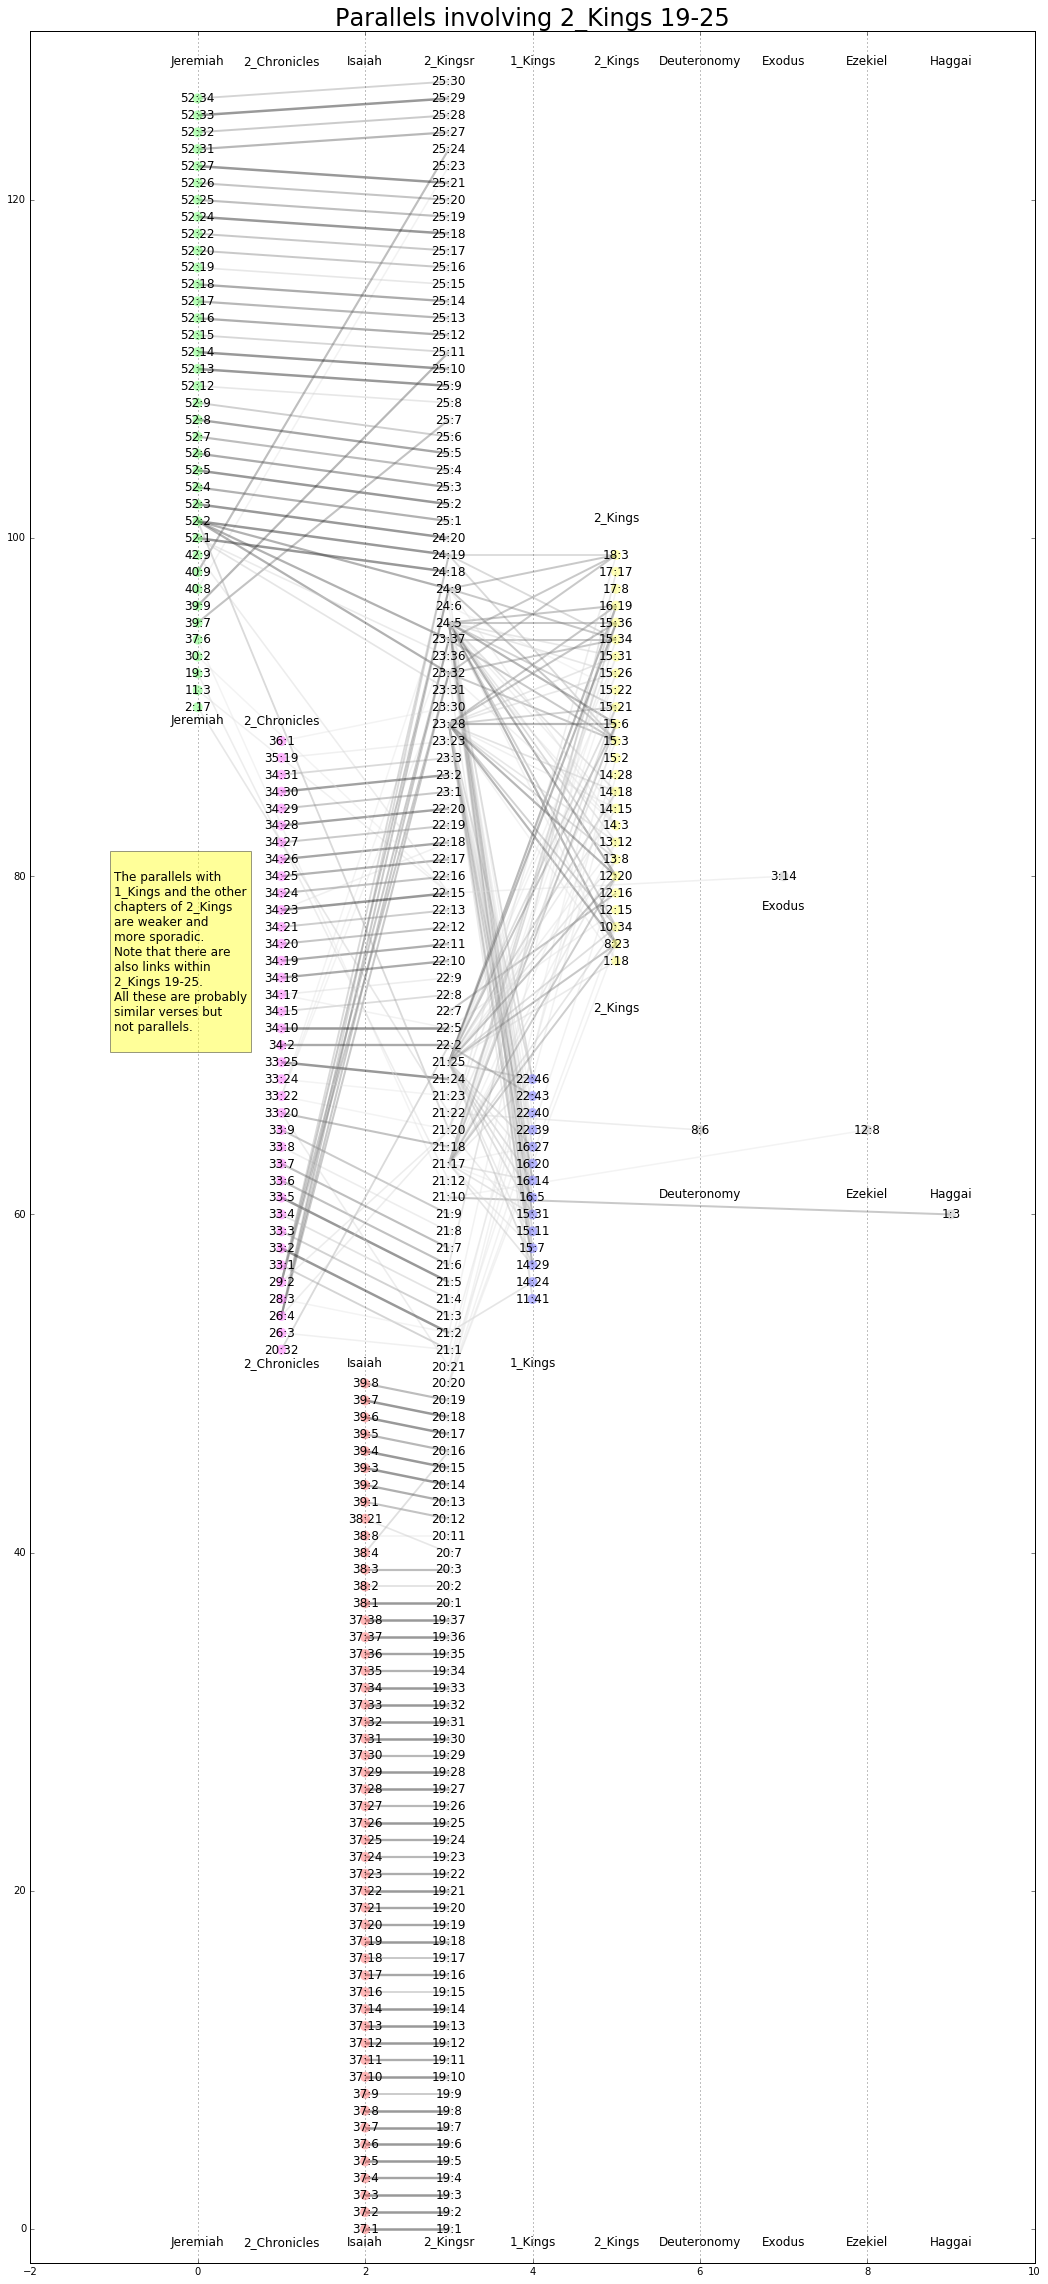

In [15]:
# read the graph data
g = nx.read_weighted_edgelist(NCOL_FILE)

# order the books for handy layout in columns
all_books_cust = '''
    Jeremiah 2_Chronicles Isaiah 2_Kingsr 1_Kings 2_Kings Deuteronomy Exodus Ezekiel Haggai 
'''.strip().split()

# specify colors of books
gcolors = {
    '2_Kingsr': (0.9, 0.9, 0.9),
    'Isaiah': (1.0, 0.3, 0.3),
    'Jeremiah': (0.3, 1.0, 0.3),
    '2_Chronicles': (1.0, 0.3, 1.0),
    '1_Kings': (0.3, 0.3, 1.0),
    '2_Kings': (1.0, 1.0, 0.3),
    'Deuteronomy': (0.7, 0.7, 0.7),
    'Exodus': (0.7, 0.7, 0.7),
    'Ezekiel': (0.7, 0.7, 0.7),
    'Haggai': (0.7, 0.7, 0.7),
}

#  specify vertical positions of passages
offset_y = {
    '2_Kingsr': 0,
    'Isaiah': 0,
    'Jeremiah': 90,
    '2_Chronicles': 52,
    '1_Kings': 55,
    '2_Kings': 75,
    'Deuteronomy': 65,
    'Exodus': 80,
    'Ezekiel': 65,
    'Haggai': 60,
}

# compute positions of verses
ncolors = [gcolors[x.split('~')[0]] for x in g.nodes()]
nlabels = dict((x, x.split('~')[1]) for x in g.nodes())
ncols = len(all_books)
pos_x = dict((x, i) for (i,x) in enumerate(all_books_cust))
verse_lists = collections.defaultdict(lambda: [])
for (bk, ch, vs) in sorted(all_verses):
    verse_lists[bk].append('{}:{}'.format(ch, vs))
nrows = max(len(verse_lists[bk]) for bk in all_books_cust)
pos = {}
for bk in verse_lists:
    for (i, chvs) in enumerate(verse_lists[bk]):
        pos['{}~{}'.format(bk, chvs)] = (pos_x[bk], i+offset_y[bk])

# start plotting
plt.figure(figsize=(18,40))

nx.draw_networkx(g, pos,
    width=[g.get_edge_data(*x)['weight']/40 for x in g.edges()],
    edge_color=[g.get_edge_data(*x)['weight'] for x in g.edges()],
    edge_cmap=plt.cm.Greys,
    edge_vmin=50,
    edge_vmax=100,
    node_color=ncolors,
    node_size=100,
    labels=nlabels,
    alpha=0.4,
    linewidths=0,
)
plt.ylim(-2, 130)
book_font_size = 12
plt.grid(b=True, which='both', axis='x')
plt.title('Parallels involving 2_Kings 19-25', fontsize=24)
plt.text(-1,70, '''
The parallels with
1_Kings and the other
chapters of 2_Kings
are weaker and 
more sporadic.
Note that there are
also links within
2_Kings 19-25.
All these are probably
similar verses but
not parallels.
''', #bbox=dict(width=145, height=200, facecolor='yellow', alpha=0.4), fontsize=12)
     # suddenly the width and height keyword args are no longer accepted.
     # bbox performs an auto fit
     bbox=dict(facecolor='yellow', alpha=0.4), fontsize=12)

# add additional book labels
for (ypos, books) in (
    (-1, all_books_cust),
    (51, ['2_Chronicles', 'Isaiah', '1_Kings']),
    (61, ['Deuteronomy', 'Ezekiel', 'Haggai']),
    (72, ['2_Kings']),
    (78, ['Exodus']),
    (89, ['2_Chronicles', 'Jeremiah']),
    (101, ['2_Kings']),
    (128, all_books_cust),
): 
    for bk in books:
        plt.text(pos_x[bk], ypos, bk, fontsize=book_font_size, horizontalalignment='center')

# save the plot as pdf
plt.savefig('kings_parallels.pdf')

From the graph above we read off which are the interesting passages to compare:

2_Kings 19-20:19 with Isaiah 37-39:8

2_Kings 21-23:3 with 2_Chronicles 33-34:31

2_Kings 23:31-25:30 with Jeremiah 52-52:34

In [16]:
focus_books = {'2_Kings', 'Isaiah', 'Jeremiah', '2_Chronicles'}

## 1.4 Similarity study

We have a closer look at the similarities between de passages as far as they are contained in the focus books.

We make a pairwise comparison of all sentences, based on the Levenshtein ratio (the similarity based on the [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance)).

First we divide the material up into sentences and fetch their texts from the database.

For this we use the function `T.words(nodes, fmt='ha')`, an
[API function](http://laf-fabric.readthedocs.org/en/latest/texts/ETCBC-reference.html#texts)
of the etcbc module of LAF-Fabric that provides several representation of the text corresponding to the given nodes.
The next cell gives an overview of the available formats.

In [17]:
for (acronym, (explanation, method)) in T.formats().items(): print('{} = {}'.format(acronym, explanation))

hp = hebrew primary
ha = hebrew accent
hv = hebrew vowel
hc = hebrew cons
ea = trans accent
ev = trans vowel
ec = trans cons
pf = phono full
ps = phono simple


### 1.4.1 Getting the sentences

For each verse, we list its sentences and store them in two lists:
* `chunks` is a list of verse-sentence references
* `chunk_data` is a list of the texts of the corresponding sentences.

We order them in a special way: first all our reference verses, i.e. 2 Kings 19-25, and then the rest in normal order.

In [21]:
msg('Identifying sentences')
crossrefs_lcs = set()
all_sentences = set()
for v in all_verse_nodes:
    for w in L.d('word', v):
        all_sentences.add(L.u('sentence', w))
msg('Found {} sentences in {} verses'.format(len(all_sentences), len(all_verse_nodes)))

msg('Grouping sentences by verse')
focus_sentences = collections.defaultdict(set)
for s in all_sentences:
    fw = L.d('word', s)[0]
    bk = T.book_name(L.u('book', fw), lang=LANG)
    if bk not in focus_books: continue
    ch = int(F.chapter.v(L.u('chapter', fw)))
    if bk in REFBOOKS and ch not in REFCHAPTERS: continue
    vs = int(F.verse.v(L.u('verse', fw)))
    focus_sentences[(bk, ch, vs)].add(s)

msg('Getting sentence texts')
chunks = []
chunk_data = []
# in the next line we order chunks such that the reference sentences come first, i.e.
# the ones from 2 Kings 19-25.
# When computing distances, if one of these verses is involved, it will
# occur in the first column, unless an other reference verse is in the first column
# It will not happen that when a reference verse is involved, 
# a non-reference verse occupies the first column
for ((bk, ch, vs), sents) in sorted(
    focus_sentences.items(),
    key=lambda x: (passage_key(x[0]), x[1])
): 
    for (sn, s) in enumerate(sorted(sents)):
        chunk_data.append(''.join(T.words(L.d('word', s), fmt='ha').replace('\n', ' ')))
        chunks.append((bk, ch, vs, sn))
msg('Done: {} sentences in {} verses'.format(len(chunks), len(focus_sentences)))
for i in range(5):
    print('{} {}'.format(chunks[i], chunk_data[i]))

14m 10s Identifying sentences
14m 10s Found 743 sentences in 296 verses
14m 10s Grouping sentences by verse
14m 10s Getting sentence texts
14m 10s Done: 682 sentences in 253 verses


('2_Kings', 19, 1, 0) וַיְהִ֗י כִּשְׁמֹ֨עַ֙ הַמֶּ֣לֶךְ חִזְקִיָּ֔הוּ 
('2_Kings', 19, 1, 1) וַיִּקְרַ֖ע אֶת־בְּגָדָ֑יו 
('2_Kings', 19, 1, 2) וַיִּתְכַּ֣ס בַּשָּׂ֔ק 
('2_Kings', 19, 1, 3) וַיָּבֹ֖א בֵּ֥ית יְהוָֽה׃ 
('2_Kings', 19, 2, 0) וַ֠יִּשְׁלַח אֶת־אֶלְיָקִ֨ים אֲשֶׁר־עַל־הַבַּ֜יִת וְשֶׁבְנָ֣א הַסֹּפֵ֗ר וְאֵת֙ זִקְנֵ֣י הַכֹּֽהֲנִ֔ים מִתְכַּסִּ֖ים בַּשַּׂקִּ֑ים אֶל־יְשַֽׁעְיָ֥הוּ הַנָּבִ֖יא בֶּן־אָמֹֽוץ׃ 


### 1.4.2 Comparing the sentences

We compare all sentences to each other.
The next cell performs the pairwise comparison by calling the Levenshtein function `ratio` for each pair.
The result is stored in the dictionary `chunk_dist`, keyed by a pair of indices in the `chunk` list and valued by the similarity of that pair.

Here is more information about the
[Levenshtein module](http://www.coli.uni-saarland.de/courses/LT1/2011/slides/Python-Levenshtein.html#Levenshtein-ratio).

In [22]:
msg('Comparing sentences and filtering the similar ones')
chunk_dist = {}
total_chunks = len(chunks)
for i in range(total_chunks):
    c_i = chunk_data[i]
    for j in range(i + 1, total_chunks):
        c_j = chunk_data[j]
        chunk_dist[(i, j)] = round(100 * ratio(c_i, c_j))
msg('Done: {} distances'.format(len(chunk_dist)))

14m 18s Comparing sentences and filtering the similar ones
14m 19s Done: 232221 distances


### 1.4.3 Analyzing the similarities

The Levenshtein ratio of arbitrary but real texts tend to be not zero, but rather something approaching 0.5.
We present an overview of how the actual similarity values of our sentence pairs are distributed.

We plot the number of comparisons against the similarities, where for each similarity value we plot the number of pairs that have at most that similarity value. 

14m 23s Analyzing similarities


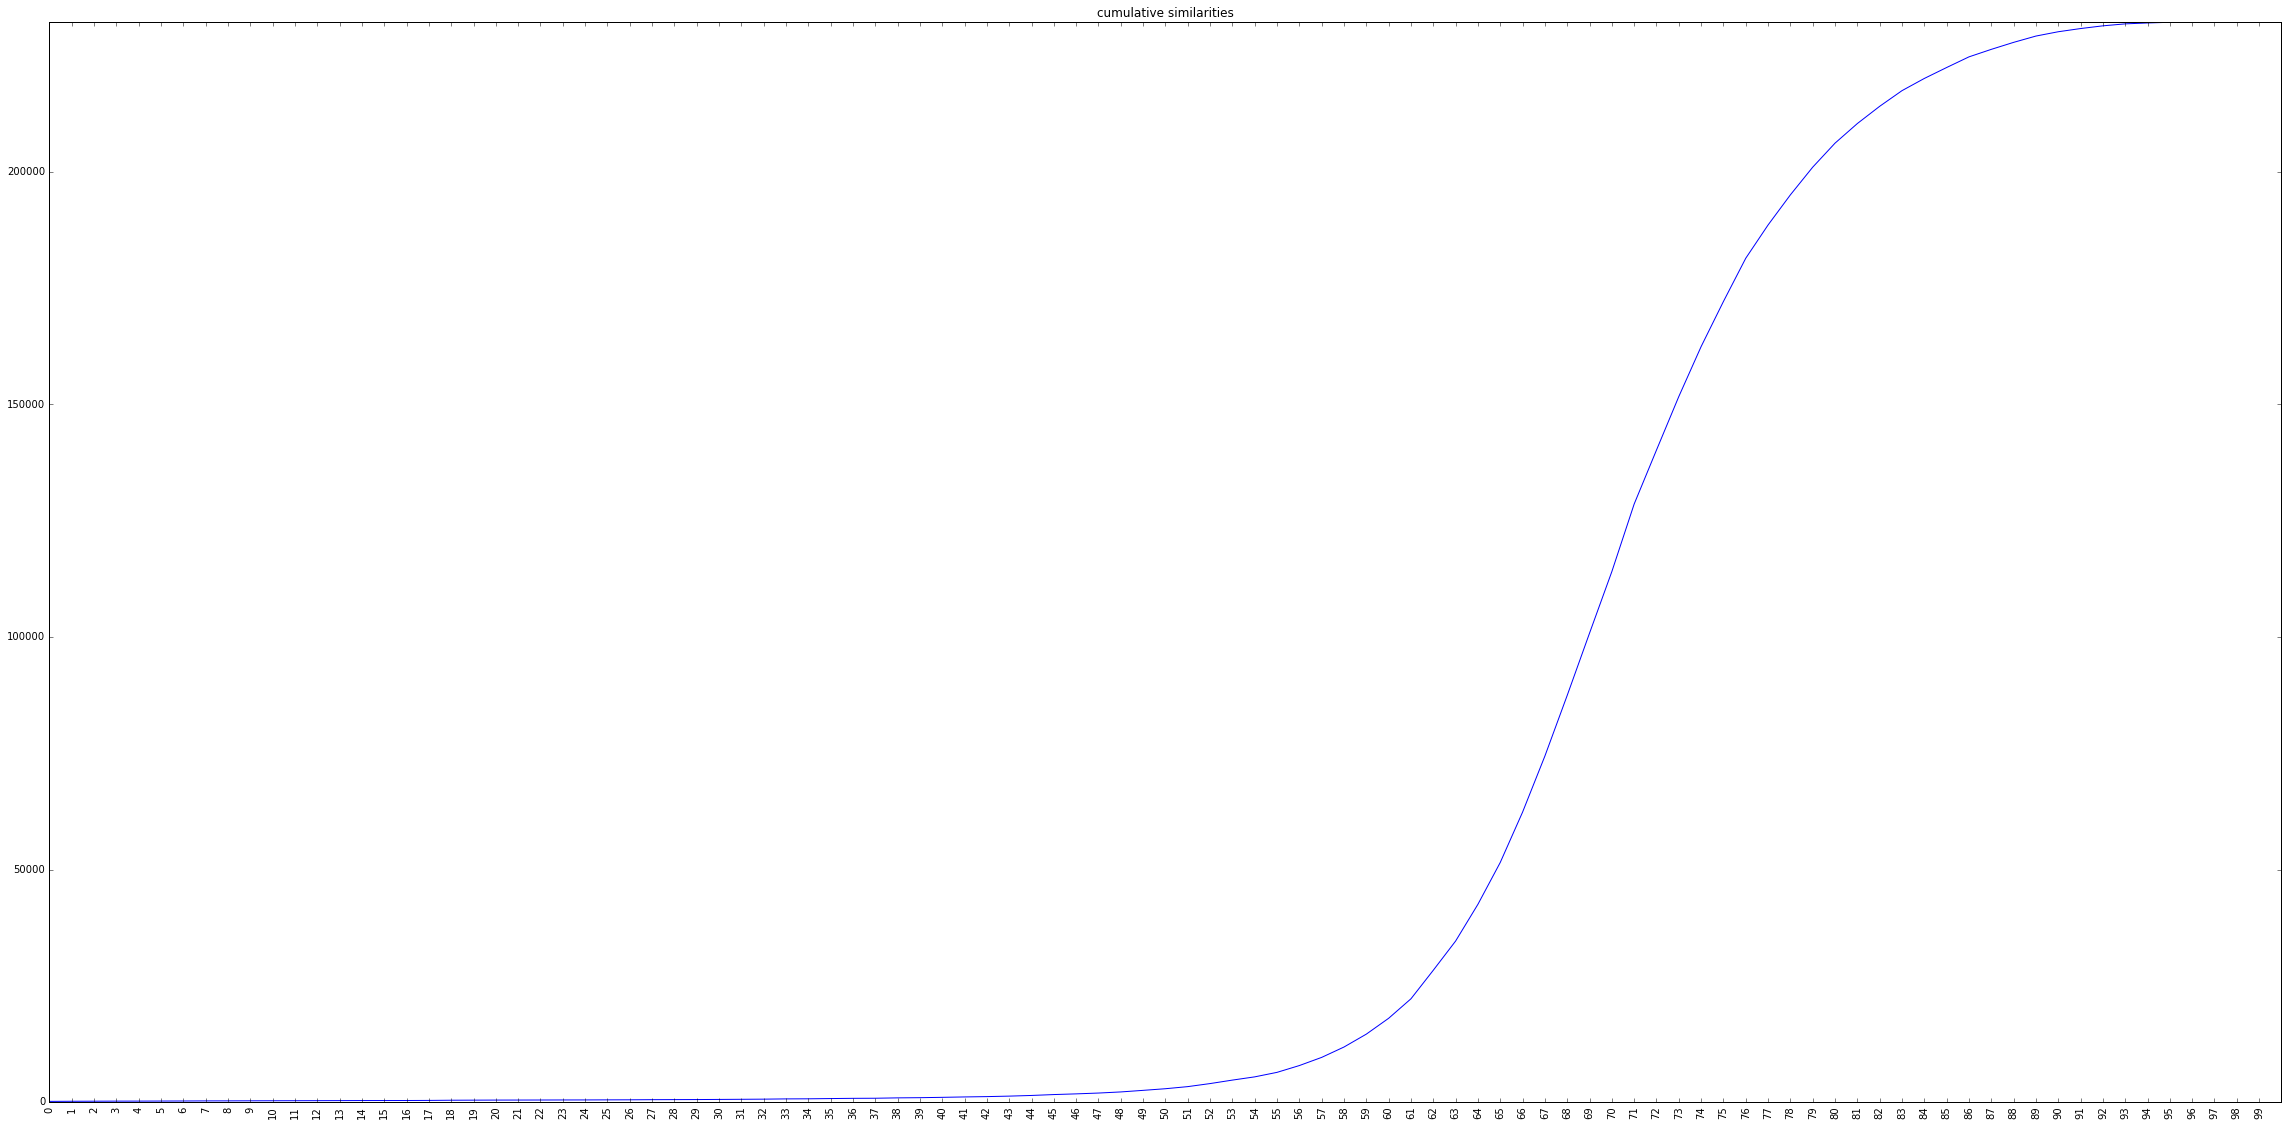

In [23]:
msg('Analyzing similarities')
sim_levels = collections.Counter()
for ((i,j), sim) in chunk_dist.items(): sim_levels[sim] += 1
cumsum = 0
sim_levels_cum = []
start = 0
end = 100

for sim in reversed(range(start, end+1)):
    cumsum += sim_levels.get(sim, 0)
    sim_levels_cum.append(cumsum)

cummax = sim_levels_cum[100]

x = range(len(sim_levels_cum))
fig = plt.figure(figsize=(40,20))
plt.plot(x[start:end], sim_levels_cum[start:end])
plt.axis([start, end, 0, cummax])
plt.xticks(x[start:end], range(start, end), rotation='vertical')
plt.margins(0.2)
plt.subplots_adjust(bottom=0.15)
plt.title('cumulative similarities')
plt.savefig('kings_similarities.pdf')

The full similarity file is [here](kings_similarities.tsv) (8 MB).
It is a tab separated file with 9 columns: 4 for book, chapter, verse, sentence number of the first sentence, another 4 for the second sentence, and the last column holds the similarity of both sentences.
See the code below.


In [24]:
msg('Writing similarities to disk')
field_template = ('{}\t' * 8) + '{}\n'
with open(SIMILAR_FILE, 'w') as f:
    f.write(field_template.format('book_1', 'chap_1', 'verse_1', 'sen_1', 'book_2', 'chap2', 'verse_2', 'sen_2', 'sim'))
    for ((i,j), sim) in sorted(chunk_dist.items()):
        f.write(field_template.format(*chunks[i], *chunks[j], sim))
msg('Done')

14m 31s Writing similarities to disk
14m 32s Done


## 1.5 Showing text differences

We are going to construct a verse-by-verse table
containing all parallels in text with difference markup.
Red and green indicate that the material is absent at the other side.
Yellow means that there is corresponding material at both sides but different.

For each verse we also give a list of the lexemes that are not shared by the two verses in that comparison.

### 1.5.1 Formatting
The table will be formatted in HTML. Therefore we specify a stylesheet.

In [25]:
css = '''
<style type="text/css">
table.t {
    width: 100%;
    border-collapse: collapse;
}
table.h {
    direction: rtl;
}
table.p {
    direction: ltr;
}
tr.t.tb {
    border-top: 2px solid #aaaaaa;
    border-left: 2px solid #aaaaaa;
    border-right: 2px solid #aaaaaa;
}
tr.t.bb {
    border-bottom: 2px solid #aaaaaa;
    border-left: 2px solid #aaaaaa;
    border-right: 2px solid #aaaaaa;
}
th.t {
    font-family: Verdana, Arial, sans-serif;
    font-size: large;
    vertical-align: middle;
    text-align: center;
    padding-left: 2em;
    padding-right: 2em;
    padding-top: 1ex;
    padding-bottom: 2ex;
    border-left: 2px solid #aaaaaa;
    border-right: 2px solid #aaaaaa;
}
td.t {
    border-left: 2px solid #aaaaaa;
    border-right: 2px solid #aaaaaa;
    padding-left: 1em;
    padding-right: 1em;
    padding-top: 0.3ex;
    padding-bottom: 0.5ex;
}
td.h {
    font-family: Ezra SIL, SBL Hebrew, Verdana, sans-serif;
    font-size: large;
    line-height: 1.6;
    text-align: right;
    direction: rtl;
}
td.ld {
    font-family: Ezra SIL, SBL Hebrew, Verdana, sans-serif;
    font-size: medium;
    line-height: 1.2;
    text-align: right;
    vertical-align: top;
    direction: rtl;
    width: 10%;
}
td.p {
    font-family: Verdana, sans-serif;
    font-size: large;
    line-height: 1.3;
    text-align: left;
    direction: ltr;
}
td.vl {
    font-family: Verdana, Arial, sans-serif;
    font-size: small;
    text-align: right;
    vertical-align: top;
    color: #aaaaaa;
    width: 5%;
    direction: ltr;
    border-left: 2px solid #aaaaaa;
    border-right: 2px solid #aaaaaa;
    padding-left: 0.4em;
    padding-right: 0.4em;
    padding-top: 0.3ex;
    padding-bottom: 0.5ex;
}
span.m {
    background-color: #aaaaff;
}
span.f {
    background-color: #ffaaaa;
}
span.x {
    background-color: #ffffaa;
    color: #bb0000;
}
span.delete {
    background-color: #ffaaaa;
}
span.insert {
    background-color: #aaffaa;
}
span.replace {
    background-color: #ffff00;
}
</style>
'''

html_file_tpl = '''<html>
<head>
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />
<title>{}</title>
{}
</head>
<body>
{}
</body>
</html>'''

### 1.5.2 Auxiliary functions
The following auxiliary functions help to wrap the text into HTML.

In [26]:
def lex_diff(c1, c2):
    b1 = T.book_node(c1[0], lang=LANG)
    b2 = T.book_node(c2[0], lang=LANG)
    v1 = T.node_of(b1, c1[1], c1[2])
    v2 = T.node_of(b2, c2[1], c2[2])
    lex1 = {F.lex_utf8.v(w).rstrip('/[=') for w in L.d('word', v1)}
    lex2 = {F.lex_utf8.v(w).rstrip('/[=') for w in L.d('word', v2)}
    return (lex1-lex2, lex2-lex1)

compare_lexemes = {}
for (c1, c2, r) in crossrefs:
    compare_lexemes[(c1, c2)] = lex_diff(c1, c2)
    
def print_label(vl, without_book=True):
    bookrep = '' if without_book else '{} '.format(vl[0])
    return '{}{}:{}'.format(bookrep, vl[1], vl[2]) if vl[0] != '' else ''

def print_diff(a, b):
    arep = ''
    brep = ''
    for (lb, ai, aj, bi, bj) in SequenceMatcher(isjunk=None, a=a, b=b, autojunk=False).get_opcodes():
        if lb == 'equal':
            arep += a[ai:aj]
            brep += b[bi:bj]
        elif lb == 'delete':
            arep += '<span class="{}">{}</span>'.format(lb, a[ai:aj])
        elif lb == 'insert':
            brep += '<span class="{}">{}</span>'.format(lb, b[bi:bj])
        else:
            arep += '<span class="{}">{}</span>'.format(lb, a[ai:aj])
            brep += '<span class="{}">{}</span>'.format(lb, b[bi:bj])
    return (arep, brep)
    
def get_vtext(v, hp):
    if hp == 'h':
        return ''.join('{}'.format(T.words(L.d('word', v), fmt='ha')))
    if hp == 'p':
        return ''.join('{}'.format(T.words(L.d('word', v), fmt='pf')))
    return ''

def print_chunk(v1, v2, hp):
    b1 = T.book_node(v1[0], lang=LANG)
    b2 = T.book_node(v2[0], lang=LANG)

    vn1 = T.node_of(b1, v1[1], v1[2])
    vn2 = T.node_of(b2, v2[1], v2[2])
    text1 = get_vtext(vn1, hp)
    text2 = get_vtext(vn2, hp)
    (lexdiff1, lexdiff2) = lex_diff(v1, v2)
    (line1, line2) = print_diff(text1, text2)
    return '''
<tr class="t tb">
    <td class="vl">{b1}</td>
    <td class="t {hp}">{l1}</td>
    <td class="t ld"><span class="delete">{ld1}</span></td>
    <td class="t ld"><span class="insert">{ld2}</span></td>
    <td class="t {hp}">{l2}</td>
    <td class="vl">{b2}</td>
</tr>
'''.format(
    b1=print_label(v1, without_book=False),
    l1=line1,
    ld1=' '.join(sorted(lexdiff1)),
    ld2=' '.join(sorted(lexdiff2)),
    b2=print_label(v2, without_book=False), 
    l2=line2,
    hp=hp,
)

def print_passage(cmp_list, hp):
    result = []
    for item in cmp_list:
        result.append(print_chunk(item[0], item[1], hp))
    return '\n'.join(result)

def get_lex_summ(book, my_own_lex):
    result = []
    for (lex, n) in sorted(my_own_lex[book].items(), key=lambda x: (-x[1], x[0])):
        result.append('<span class="ld">{}</span>&nbsp;{}<br/>'.format(lex, n))
    return '\n'.join(result)
    
def print_lexeme_summary(book1, book2, my_own_lex):
    return '''
<tr class="t tb">
    <td class="vl">&nbsp;</td>
    <td class="t">&nbsp;</td>
    <td class="t ld"><span class="delete">{ld1}</span></td>
    <td class="t ld"><span class="insert">{ld2}</span></td>
    <td class="t">&nbsp;</td>
    <td class="vl">&nbsp;</td>
</tr>
'''.format(
        ldr=get_lex_summ(book1, my_own_lex),
        ldp=get_lex_summ(book2, my_own_lex),
    )

def print_table(hp):
    result = '''
<table class="t {}">
'''.format(hp)

    result += print_passage(sorted(crossrefs), hp)
    
    result += '''
</table>
'''
    return result

### 1.5.3 Delivering results
And here we put everything together and produce the html (in fully pointed Hebrew and in a phonetic transcription) and save it to file.

In [27]:
html_text_h = html_file_tpl.format(
    '2 Kings 19-26 and parallels [Hebrew]',
    css,
    print_table('h'),
)
html_text_p = html_file_tpl.format(
    '2 Kings 19-26 and parallels [phonetic]',
    css,
    print_table('p'),
)
ht = open('kings_parallels_h.html', 'w')
ht.write(html_text_h)
ht.close()
ht = open('kings_parallels_p.html', 'w')
ht.write(html_text_p)
ht.close()

# 2. Qumran Scroll 1QIsa<sup>a</sup>

Here we read the transcribed text of 1QIsa<sup>a</sup> and store it in the variable `qisa`.

In [28]:
msg('reading 1QIsaa')
qf = open(QISA_FILE)
qisa = collections.defaultdict(lambda: collections.defaultdict(lambda: []))
nwords = 0
for line in qf:
    nwords += 1
    (passage, word, xword) = line.strip().split()
    (chapter, verse) = passage.split(',')
    qisa[int(chapter)][int(verse)].append(Transcription.to_hebrew_x(word))
qf.close()
msg('{} words in {} chapters in {} verses'.format(nwords, len(qisa), sum(len(qisa[x]) for x in qisa)))
print(' '.join(qisa[1][1]))

17m 22s reading 1QIsaa
17m 22s 16862 words in 66 chapters in 1290 verses


חזונ ישׁעיהו בנ אמוצ אשׁר חזה על יהודה וירושׁלמ ביומי עוזיה יותמ אחז יחזקיה מלכי יהודה


## 2.1 Auxiliary functions
Here are the functions to make comparisons with the Qumran (1QIsa<sup>a</sup>) text.

Note that the Qumran text is unpointed, so we compare it with an unpointed representation of the Masoretic text.
We also strip the marks from the s(h)in letter, so that we ignore any distinction between sin and shin in both sources.

In [29]:
wh = '10px'
wn = '10px'
ww = '200px'

diffhead = '''
<head>
    <meta http-equiv="Content-Type"
          content="text/html; charset=UTF-8" />
    <title></title>
    <style type="text/css">
        table.diff {{
            font-family: Ezra SIL, SBL Hebrew, Verdana, sans-serif; 
            font-size: large;
            text-align: right;
            width: 100%;
        }}
        td, th {{padding-left: 4px; padding-right: 4px}}
        td[nowrap] {{width: {ww}; min-width: {ww}; max-width: {ww}; }}
        th.diff_next {{width: {wn}; min-width: {wn}; max-width: {wn}; }}
        td.diff_next {{text-align:left; font-size: small; width: {wn}; min-width: {wn}; max-width: {wn}; }}
        .diff_next {{background-color:#c0c0c0; font-size: small}}
        th.diff_header {{width: {wh}; min-width: {wh}; max-width: {wh}; }}
        td.diff_header {{text-align:left; width: {wh}; min-width: {wh}; max-width: {wh}; }}
        .diff_header {{background-color:#e0e0e0; font-size: small}}
        .diff_add {{background-color:#aaffaa}}
        .diff_chg {{background-color:#ffff77}}
        .diff_sub {{background-color:#ffaaaa}}
    </style>
</head>
'''.format(wh=wh, wn=wn, ww=ww)

def shin(x): return x.replace(
        '\uFB2A'
        ,'ש'
).replace(
        '\uFB2B',
        'ש'
)

def lines_chapter_mt(ch):
    vn = T.node_of(T.book_node('Isaiah', lang=LANG), ch, 1)
    cn = L.u('chapter', vn)
    lines = []
    for v in L.d('verse', cn):
        vl = F.verse.v(v)
        text = T.words(L.d('word', v), fmt='hc').\
            replace('\u05BE',' ').\
            replace('\u05C3', '') # maqef and sof pasuq
        #lines.append('{} {}'.format(vl, text))
        lines.append(text)

    return lines

def lines_chapter_1q(ch):
    lines = []
    for v in qisa[ch]:
        text = ' '.join(qisa[ch][v])
        #lines.append('{} {}'.format(v, shin(text.strip())))
        lines.append(shin(text.strip()))
    return lines

def compare_chapters(c1, c2, lb1, lb2, head=True):
    dh = difflib.HtmlDiff(wrapcolumn=50)
    table_html = dh.make_table(
        c1, 
        c2, 
        fromdesc=lb1, 
        todesc=lb2, 
        context=False, 
        numlines=5,
    )
    htext = '''<html>{}<body>{}</body></html>'''.format(diffhead, table_html) if head else table_html
    return htext

def mt1q_chapter_diff(ch, head=True):
    lines_mt = lines_chapter_mt(ch)
    lines_1q = lines_chapter_1q(ch)
    return compare_chapters(
        lines_mt, 
        lines_1q, 
        'Isaiah {} MT'.format(ch), 
        'Isaiah {} 1QIsa<sup>a</sup>'.format(ch), 
        head=head,
)

## 2.2 Delivery of results
And next we produce the actual html results.

In [30]:
for ch in range(37,40):
    ht = open('Isaiah-mt-1QIsaa_{}.html'.format(ch), 'w')
    ht.write(mt1q_chapter_diff(ch))
    ht.close()

# Now the whole of Isaiah
ht = open('Isaiah-mt-1QIsaa.html', 'w')
ht.write('''<html>{}<body>'''.format(diffhead))
for ch in range (1, 67):
    ht.write(mt1q_chapter_diff(ch, head=False))
ht.write('''</body></html>''')
ht.close()